In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import random

In [2]:
df = pd.read_csv("./additional/insurance.csv")

In [3]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
# Уникальные значения в 'region'
unique_regions = df['region'].unique()
f"{len(unique_regions)}: {unique_regions}"

"4: ['southwest' 'southeast' 'northwest' 'northeast']"

In [6]:
# Преобразование столбца 'sex': female → 0, male → 1
df['sex'] = df['sex'].map({'female': 0, 'male': 1})

# Преобразование столбца 'smoker': no → 0, yes → 1
df['smoker'] = df['smoker'].map({'no': 0, 'yes': 1})

# Преобразование столбца 'region' в числовой формат
df['region'] = df['region'].astype('category').cat.codes

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   int8   
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(4), int8(1)
memory usage: 64.2 KB


In [8]:
corr_matrix = df.corr() # расчёт корреляции
target_corr = corr_matrix['charges'].sort_values(ascending=False)
# Отсортируем признаки по модулю корреляции с целевой переменной:
target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

charges     1.000000
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region     -0.006208
Name: charges, dtype: float64

In [9]:
df['region'].unique()

array([3, 2, 1, 0], dtype=int8)

In [10]:
X = df.drop('charges', axis=1).values
Y = df['charges'].values

# сразу нормализуем наши значения
scaler = StandardScaler() # z-score нормализация
X_scaled = scaler.fit_transform(X)
Y_log = np.log1p(Y)

In [11]:
# разобьём на тренировочный и тестовый сеты данных
indices = list(range(len(X_scaled)))
random.shuffle(indices)
split = int(0.8 * len(X_scaled))
train_idx = indices[:split]
test_idx = indices[split:]

X_train = X_scaled[train_idx]
Y_train = Y_log[train_idx].reshape(-1, 1)
X_test = X_scaled[test_idx]
Y_test = Y_log[test_idx].reshape(-1, 1)

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, Y_train.ravel(), cv=5,
        scoring='neg_mean_absolute_error',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Train MAE')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Test MAE')
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# ЛИНЕЙНАЯ РЕГРЕССИЯ
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Обучение модели
model = LinearRegression()
model.fit(X_train, Y_train)

# Предсказания
Y_pred = model.predict(X_test)
Y_pred_original = np.expm1(Y_pred)
Y_test_original = np.expm1(Y_test)

# Метрики
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)

# "Точность" как доля предсказаний, где ошибка меньше заданного порога (0.5)
threshold = 0.5
accuracy = (abs(Y_test - Y_pred) < threshold).mean()

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
f"Accuracy (с порогом {threshold}): {accuracy:.4f}"

MAE: 0.2946
MSE: 0.2254


'Accuracy (с порогом 0.5): 0.8097'

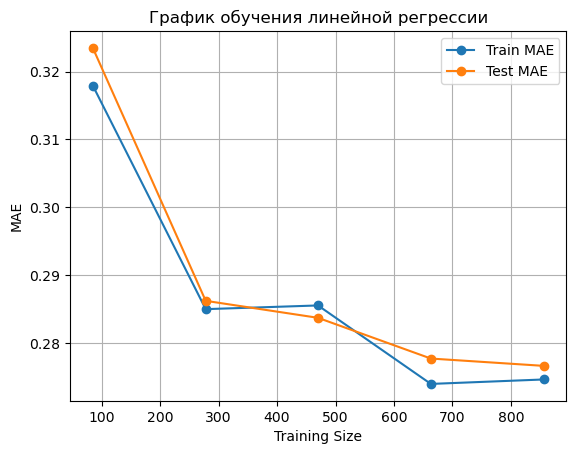

In [14]:
plot_learning_curve(model, "График обучения линейной регрессии")

In [15]:
# МЕТОД ОПОРНЫХ ВЕКТОРОВ
from sklearn.svm import SVR

# Инициализация модели SVR
svr_model = SVR(kernel='rbf')  # 'linear', 'poly', 'sigmoid'

# Обучение модели
svr_model.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_svr = svr_model.predict(X_test)

# Метрики
mae_svr = mean_absolute_error(Y_test, Y_pred_svr)
mse_svr = mean_squared_error(Y_test, Y_pred_svr)

# "Точность" с порогом
threshold = 0.5
accuracy_svr = (abs(Y_test - Y_pred_svr) < threshold).mean()

print(f"SVR MAE: {mae_svr:.4f}")
print(f"SVR MSE: {mse_svr:.4f}")
f"SVR Accuracy (с порогом {threshold}): {accuracy_svr:.4f}"

SVR MAE: 0.1813
SVR MSE: 0.1709


'SVR Accuracy (с порогом 0.5): 0.3074'

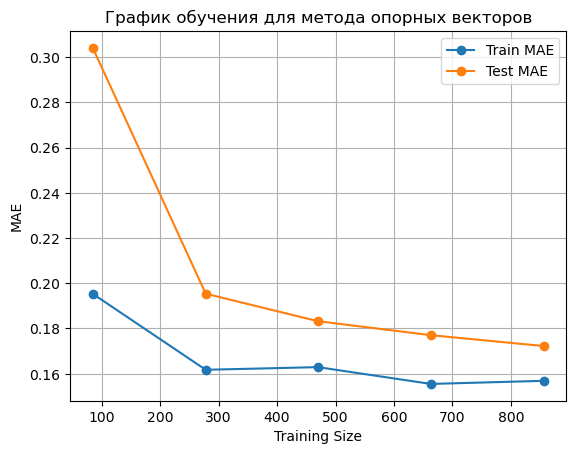

In [16]:
plot_learning_curve(svr_model, "График обучения для метода опорных векторов")

In [17]:
# ДЕРЕВО РЕШЕНИЙ
from sklearn.tree import DecisionTreeRegressor

# Инициализация модели
tree_model = DecisionTreeRegressor(random_state=42)

# Обучение модели
tree_model.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_tree = tree_model.predict(X_test)

# Метрики
mae_tree = mean_absolute_error(Y_test, Y_pred_tree)
mse_tree = mean_squared_error(Y_test, Y_pred_tree)

# "Точность"
threshold = 0.5
accuracy_tree = (abs(Y_test - Y_pred_tree) < threshold).mean()

print(f"Decision Tree MAE: {mae_tree:.4f}")
print(f"Decision Tree MSE: {mse_tree:.4f}")
f"Decision Tree Accuracy (с порогом {threshold}): {accuracy_tree:.4f}"

Decision Tree MAE: 0.2522
Decision Tree MSE: 0.3298


'Decision Tree Accuracy (с порогом 0.5): 0.2985'

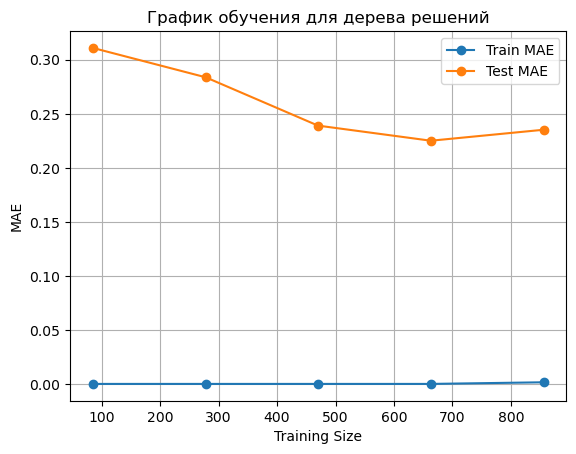

In [18]:
plot_learning_curve(tree_model, "График обучения для дерева решений")

In [19]:
# RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor

# Инициализация модели
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Обучение модели
rf_model.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_rf = rf_model.predict(X_test)

# Метрики
mae_rf = mean_absolute_error(Y_test, Y_pred_rf)
mse_rf = mean_squared_error(Y_test, Y_pred_rf)

# "Точность" с порогом
threshold = 0.5
accuracy_rf = (abs(Y_test - Y_pred_rf) < threshold).mean()

print(f"Random Forest MAE: {mae_rf:.4f}")
print(f"Random Forest MSE: {mse_rf:.4f}")
f"Random Forest Accuracy (с порогом {threshold}): {accuracy_rf:.4f}"

Random Forest MAE: 0.2045
Random Forest MSE: 0.1873


'Random Forest Accuracy (с порогом 0.5): 0.3145'

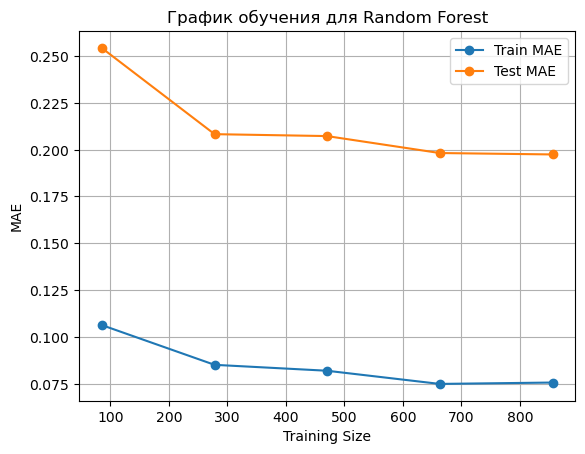

In [20]:
plot_learning_curve(rf_model, "График обучения для Random Forest")

In [21]:
# GRADIENT BOOSTING
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Инициализация модели
gb_model = GradientBoostingRegressor(
    n_estimators=200,       # количество деревьев
    learning_rate=0.1,      
    max_depth=4,            # max глубина каждого дерева
    random_state=42
)

# Обучение модели
gb_model.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_gb = gb_model.predict(X_test)

# Метрики
mae_gb = mean_absolute_error(Y_test, Y_pred_gb)
mse_gb = mean_squared_error(Y_test, Y_pred_gb)

# "Точность" с порогом
threshold = 0.5
accuracy_gb = (abs(Y_test - Y_pred_gb) < threshold).mean()

print(f"Gradient Boosting MAE: {mae_gb:.4f}")
print(f"Gradient Boosting MSE: {mse_gb:.4f}")
f"Gradient Boosting Accuracy (с порогом {threshold}): {accuracy_gb:.4f}"

Gradient Boosting MAE: 0.2099
Gradient Boosting MSE: 0.1753


'Gradient Boosting Accuracy (с порогом 0.5): 0.3138'

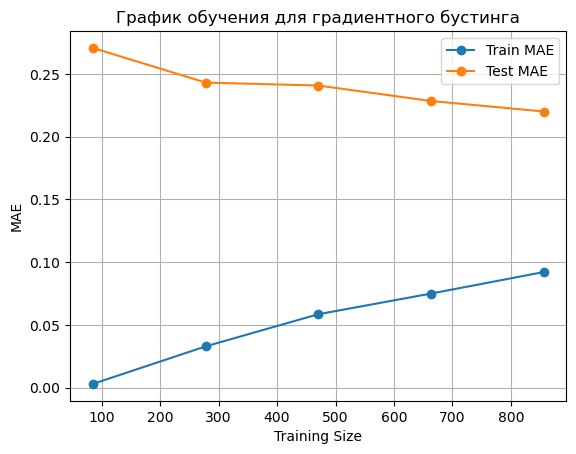

In [22]:
plot_learning_curve(gb_model, "График обучения для градиентного бустинга")

In [23]:
# XGBoost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Инициализация модели
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Обучение модели
xgb_model.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_xgb = xgb_model.predict(X_test)

# Метрики
mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb)
mse_xgb = mean_squared_error(Y_test, Y_pred_xgb)

# "Точность" с порогом
threshold = 0.5
accuracy_xgb = (abs(Y_test - Y_pred_xgb) < threshold).mean()

print(f"XGBoost MAE: {mae_xgb:.4f}")
print(f"XGBoost MSE: {mse_xgb:.4f}")
f"XGBoost Accuracy (с порогом {threshold}): {accuracy_xgb:.4f}"

XGBoost MAE: 0.2189
XGBoost MSE: 0.1776


'XGBoost Accuracy (с порогом 0.5): 0.3163'

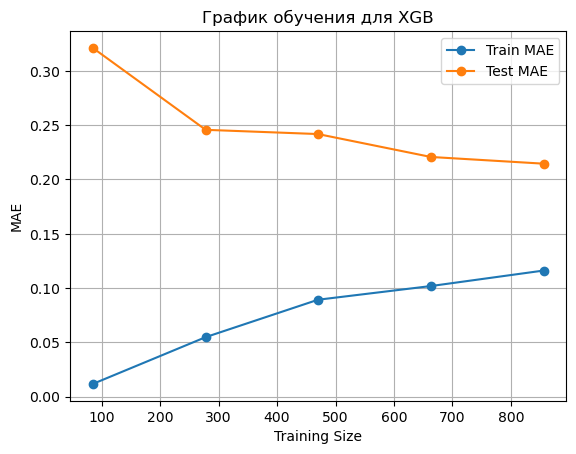

In [24]:
plot_learning_curve(xgb_model, "График обучения для XGB")

In [25]:
# CATBOOST
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Инициализация модели
cat_model = CatBoostRegressor(
    iterations=500,        
    learning_rate=0.05,     
    verbose=0,            
    random_state=42
)

# Обучение модели
cat_model.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_cat = cat_model.predict(X_test)

# Метрики
mae_cat = mean_absolute_error(Y_test, Y_pred_cat)
mse_cat = mean_squared_error(Y_test, Y_pred_cat)

# "Точность" с порогом
threshold = 0.5
accuracy_cat = (abs(Y_test - Y_pred_cat) < threshold).mean()

print(f"CatBoost MAE: {mae_cat:.4f}")
print(f"CatBoost MSE: {mse_cat:.4f}")
f"CatBoost Accuracy (с порогом {threshold}): {accuracy_cat:.4f}"

CatBoost MAE: 0.2147
CatBoost MSE: 0.1762


'CatBoost Accuracy (с порогом 0.5): 0.3137'

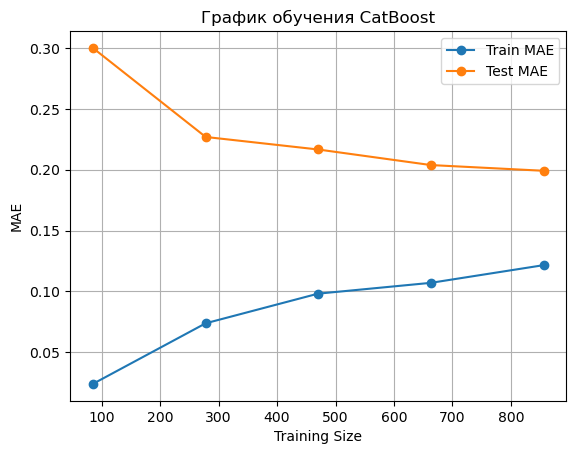

In [26]:
plot_learning_curve(cat_model, "График обучения CatBoost")

In [27]:
# LightGBM
import lightgbm as lgb

# Инициализация модели
lgb_model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose = 0
)

# Обучение модели
lgb_model.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_lgb = lgb_model.predict(X_test)

# Метрики
mae_lgb = mean_absolute_error(Y_test, Y_pred_lgb)
mse_lgb = mean_squared_error(Y_test, Y_pred_lgb)

# "Точность"
threshold = 0.5
accuracy_lgb = (abs(Y_test - Y_pred_lgb) < threshold).mean()

print(f"LightGBM MAE: {mae_lgb:.4f}")
print(f"LightGBM MSE: {mse_lgb:.4f}")
f"LightGBM Accuracy (с порогом {threshold}): {accuracy_lgb:.4f}"

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


'LightGBM Accuracy (с порогом 0.5): 0.3158'

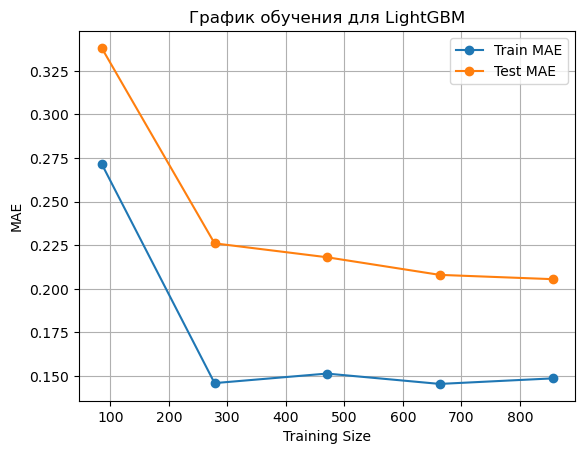

In [28]:
plot_learning_curve(lgb_model, "График обучения для LightGBM")

In [29]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'SVR', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'LightGBM'],
    'MAE': [mae, mae_svr, mae_tree, mae_rf, mae_gb, mae_xgb, mae_cat, mae_lgb],
    'MSE': [mse, mse_svr, mse_tree, mse_rf, mse_gb, mse_xgb, mse_cat, mse_lgb],
    'Accuracy (порог 0.5)': [accuracy, accuracy_svr, accuracy_tree, accuracy_rf, accuracy_gb, accuracy_xgb, accuracy_cat, accuracy_lgb]
})

print(results.sort_values(by='MAE'))

               Model       MAE       MSE  Accuracy (порог 0.5)
1                SVR  0.181346  0.170907              0.307446
3      Random Forest  0.204522  0.187261              0.314463
7           LightGBM  0.207223  0.169788              0.315814
4  Gradient Boosting  0.209942  0.175256              0.313823
6           CatBoost  0.214676  0.176204              0.313683
5            XGBoost  0.218891  0.177556              0.316329
2      Decision Tree  0.252232  0.329845              0.298452
0  Linear Regression  0.294615  0.225370              0.809701


In [30]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score # mae

# Пространство поиска гиперпараметров
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1)
}

# Целевая функция
def objective(params):
    model = GradientBoostingRegressor(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        random_state=42
    )
    score = cross_val_score(model, X_train, Y_train.ravel(), cv=5, scoring='neg_mean_absolute_error')
    return {'loss': -score.mean(), 'status': STATUS_OK}

# Запуск оптимизации
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Лучшие параметры:", best)

100%|███████████████████████████████████████████████| 50/50 [03:09<00:00,  3.79s/trial, best loss: 0.18972115611360005]
Лучшие параметры: {'learning_rate': np.float64(0.01032260571505173), 'max_depth': np.float64(5.0), 'min_samples_leaf': np.float64(11.0), 'min_samples_split': np.float64(20.0), 'n_estimators': np.float64(500.0)}


In [31]:
# GRADIENT BOOSTING OPTIMIZED
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Инициализация модели
gb_model_opt = GradientBoostingRegressor(
    learning_rate=0.0854345399482471,  
    min_samples_leaf=3,
    min_samples_split=12,
    n_estimators=150,
    max_depth=3,            # max глубина каждого дерева
    random_state=42
)

# Обучение модели
gb_model_opt.fit(X_train, Y_train.ravel())

# Предсказания
Y_pred_gb = gb_model_opt.predict(X_test)

# Метрики
mae_gb_opt = mean_absolute_error(Y_test, Y_pred_gb)
mse_gb_opt = mean_squared_error(Y_test, Y_pred_gb)

# "Точность" с порогом
threshold = 0.5
accuracy_gb_opt = (abs(Y_test - Y_pred_gb) < threshold).mean()

print(f"Optimized Gradient Boosting MAE: {mae_gb_opt:.4f}")
print(f"Optimized Gradient Boosting MSE: {mse_gb_opt:.4f}")
f"Optimized Gradient Boosting Accuracy (с порогом {threshold}): {accuracy_gb_opt:.4f}"

Optimized Gradient Boosting MAE: 0.1992
Optimized Gradient Boosting MSE: 0.1661


'Optimized Gradient Boosting Accuracy (с порогом 0.5): 0.3168'

In [32]:
results_optimized = pd.DataFrame({
    'Model': ['Linear Regression', 'SVR', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'CatBoost', 'LightGBM', 'GB opt'],
    'MAE': [mae, mae_svr, mae_tree, mae_rf, mae_gb, mae_xgb, mae_cat, mae_lgb, mae_gb_opt],
    'MSE': [mse, mse_svr, mse_tree, mse_rf, mse_gb, mse_xgb, mse_cat, mse_lgb, mse_gb_opt],
    'Accuracy (порог 0.5)': [accuracy, accuracy_svr, accuracy_tree, accuracy_rf, accuracy_gb, accuracy_xgb, accuracy_cat, accuracy_lgb, accuracy_gb_opt]
})

print(results_optimized.sort_values(by='MAE'))

               Model       MAE       MSE  Accuracy (порог 0.5)
1                SVR  0.181346  0.170907              0.307446
8             GB opt  0.199196  0.166059              0.316788
3      Random Forest  0.204522  0.187261              0.314463
7           LightGBM  0.207223  0.169788              0.315814
4  Gradient Boosting  0.209942  0.175256              0.313823
6           CatBoost  0.214676  0.176204              0.313683
5            XGBoost  0.218891  0.177556              0.316329
2      Decision Tree  0.252232  0.329845              0.298452
0  Linear Regression  0.294615  0.225370              0.809701


In [33]:
Y_pred_gb_1 = gb_model_opt.predict(X_test)
print(Y_pred_gb_1[1])
Y_test[1]

9.070628897629518


array([9.01603904])

In [34]:
Y_pred_gb_1 = gb_model_opt.predict(X_test)
print(Y_pred_gb_1[2])
Y_test[2]

10.562889052933334


array([10.63735917])

In [35]:
Y_pred_gb_1 = gb_model_opt.predict(X)
print(Y_pred_gb_1[2])
Y[2]

9.595206872026472


np.float64(4449.462)